# M-estimation
This notebook walksthrough the examples provided in the "A Survey of Estimating Functions" section of the presentation

In [1]:
import numpy as np
import pandas as pd
import patsy
import matplotlib.pyplot as plt
%matplotlib inline

from delicatessen import MEstimator
from delicatessen.estimating_equations import (ee_regression, ee_robust_regression, ee_ridge_regression,
                                               ee_3p_logistic, ee_effective_dose_delta,
                                               ee_aft_weibull)
from delicatessen.data import load_robust_regress, load_inderjit
from delicatessen.utilities import inverse_logit

## Mean

In [2]:
y = np.array([1, 5, 3, 7, 24])

### Simple Mean

In [3]:
def simple_mean(theta):
    return y - theta


estr = MEstimator(simple_mean, init=[0, ])
estr.estimate()

print(estr.theta)
print(estr.variance)

[8.]
[[13.59999775]]


### Robust Mean

In [4]:
def robust_mean(theta):
    k = 4
    ee_rm = y - theta
    ee_rm = np.where(ee_rm > k, k, ee_rm)
    ee_rm = np.where(ee_rm < -k, -k, ee_rm)
    return ee_rm


estr = MEstimator(robust_mean, init=[6, ])
estr.estimate()

print(estr.theta)
print(estr.variance)

[5.]
[[3.26530558]]


As seen in the results, the robust mean is less sensitive to the outlier (the robust mean is 'closer' to the other observations). Additionally, the estimated variance is substantially smaller (another benefit of the robust mean).

## Regression
To start with, we will use some simulated data to showcase simple linear regression and robust linear regression. Here, we will regress weight as a function of height

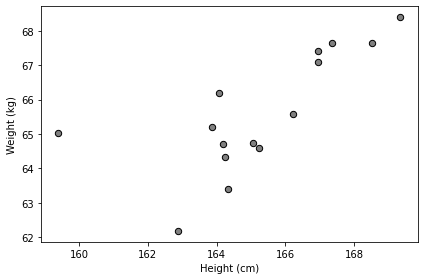

In [5]:
# Loading and setting up the data
d = load_robust_regress(outlier=True)      # Load the corresponding data
x = d[:, 0]                                # Extract the independent variable
y = d[:, 1]                                # Extract the dependent variable
X = np.vstack((np.ones(x.shape[0]), x)).T  # Generate array of intercept and X values

# Scatter plot of the available data
plt.scatter(x, y, s=40, c='gray', edgecolors='k', label=None, zorder=4)
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.tight_layout()

As seen, the data point with a height below 160 seems to be an outlier (I generated the data here, so I know that data point *is* an outlier for the mechanism).

### Simple Regression

In [6]:
def simple_regression(theta):
    return ee_regression(theta=theta,
                         X=X,
                         y=y,
                         model='linear')


# Linear regression with the outlier
sreg = MEstimator(simple_regression, 
                  init=[0., 0.])
sreg.estimate(solver='lm')

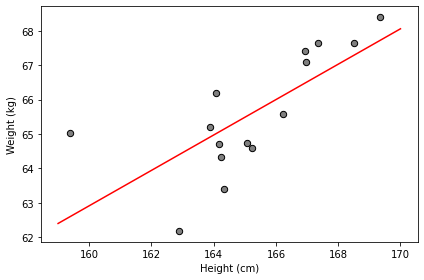

In [7]:
# Plot of regression results
xlin = np.linspace(159, 170, 100)

plt.plot(xlin, sreg.theta[0] + xlin*sreg.theta[1], '-', color='red')
plt.scatter(x, y, s=40, c='gray', edgecolors='k', label=None, zorder=4)
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.tight_layout()

### Robust Regression

In [8]:
def robust_regression(theta):
    return ee_robust_regression(theta=theta,
                                X=X,
                                y=y,
                                model='linear',
                                k=1.345)


# Linear regression with the outlier
rreg = MEstimator(robust_regression, 
                  init=sreg.theta)     # Here we use the previous as initial values
rreg.estimate(solver='lm')

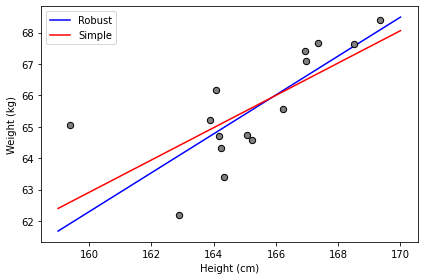

In [9]:
# Plot of regression results
plt.plot(xlin, rreg.theta[0] + xlin*rreg.theta[1], '-', color='blue', label='Robust')
plt.plot(xlin, sreg.theta[0] + xlin*sreg.theta[1], '-', color='red', label='Simple')
plt.scatter(x, y, s=40, c='gray', edgecolors='k', label=None, zorder=4)
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.legend()
plt.tight_layout()

Here, the red line (simple linear regression) is pulled up to the outlier on the left. This means the right has to decrease to compensate for this change. As seen in the robust linear regression, the outlier has less influence on the overall slope of the line.

### Penalized Regression
Penalized regression can also be written as an estimating function. Below is an example with ridge-regression ($L_2$ penalty)

In [10]:
# Generating some data with noise and correlation
n = 500
data = pd.DataFrame()
data['V'] = np.random.normal(size=n)
data['W'] = np.random.normal(size=n)
data['X'] = data['W'] + np.random.normal(scale=0.25, size=n)
data['Z'] = np.random.normal(size=n)
data['Y'] = 0.5 + 2 * data['W'] - 1 * data['Z'] + np.random.normal(loc=0, size=n)
data['intercept'] = 1

In [11]:
def simple_regression(theta):
    x, y = data[['intercept', 'V', 'W', 'X', 'Z']], data['Y']
    return ee_regression(theta=theta, X=x, y=y, 
                         model='linear')

estr = MEstimator(simple_regression, init=[0.01, 0.01, 0.01, 0.01, 0.01])
estr.estimate(solver='lm', maxiter=5000)
print('Simple:', estr.theta)

Simple: [ 0.53677675 -0.04373764  2.0747961  -0.09571196 -0.98159361]


In [12]:
def ridge_regression(theta):
    x, y = data[['intercept', 'V', 'W', 'X', 'Z']], data['Y']
    return ee_ridge_regression(theta=theta, X=x, y=y, model='linear',
                               penalty=[0., 10., 10., 10., 10.],
                               center=0)

estr = MEstimator(ridge_regression, init=[0.01, 0.01, 0.01, 0.01, 0.01])
estr.estimate(solver='lm', maxiter=5000)
print('Ridge:', estr.theta)

Ridge: [ 0.53873128 -0.0379371   1.62374835  0.31866021 -0.95564888]


As shown, the parameters shrink towards zero with ridge regression.

### 3-Parameter Logistic Regression
A separate type of regression is a variation on logistic models for estimating dose-response curves. These model have parameters for the upper bound on the response, the lower bound on the response, the 50th percentile effective dose, and the steepness of the dose-response curve.

The following example estimates the dose-response curve for herbicide on root length. Here, a 3-parameter logistic model is estimated (since the minimum root length is zero).

In [13]:
d = load_inderjit()

In [14]:
def log3p(theta):
    return ee_3p_logistic(theta=theta[0:3], 
                          X=d[:, 1], y=d[:, 0], 
                          lower=0)

mest = MEstimator(log3p, init=[2, 1, 10])
mest.estimate(solver='lm', maxiter=2000)
ci_theta = mest.confidence_intervals()

In [15]:
print("ED(50)")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[0], 2))
print("95% CI:", np.round(ci_theta[0], 2))
print("----------------------------------")
print("Steepness")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[1], 2))
print("95% CI:", np.round(ci_theta[1], 2))
print("----------------------------------")
print("Upper Limit")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[2], 2))
print("95% CI:", np.round(ci_theta[2], 2))

ED(50)
----------------------------------
Est:    3.26
95% CI: [2.74 3.78]
----------------------------------
Steepness
----------------------------------
Est:    2.47
95% CI: [1.9  3.04]
----------------------------------
Upper Limit
----------------------------------
Est:    7.86
95% CI: [7.55 8.16]


It is also easy to get the effective concentration at other percentiles (and the corresponding confidence intervals via the sandwich variance). The effective concentration at the other percentiles is simply a transformation of the logistic model parameters.

In [16]:
def log3ped(theta):
    # Estimating equations for the 3PL model
    pl3 = ee_3p_logistic(theta=theta[0:3], 
                         X=d[:, 1], y=d[:, 0], 
                         lower=0)
    # Estimating equations for the effective concentrations
    ed20 = ee_effective_dose_delta(theta[3], y=d[:, 0], delta=0.20,
                                   steepness=theta[0], ed50=theta[1],
                                   lower=0, upper=theta[2])
    return np.vstack((pl3,
                      ed20))

mest = MEstimator(log3ped, init=[3.3, 2.5, 7.9, 1])
mest.estimate(solver='lm', maxiter=2000)
ci_theta = mest.confidence_intervals()

In [17]:
print("ED(20)")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[3], 2))
print("95% CI:", np.round(ci_theta[3], 2))

ED(20)
----------------------------------
Est:    1.86
95% CI: [1.58 2.14]


## Causal Methods
A variety of causal inference methods can also be written as M-estimators. Here, we will go through several estimators. I will use the example from Morris et al. (2022), which uses data from Wilson et al. (2017). The Wilson data can be downloaded from the *PLOS Medicine* article.

In [18]:
d = pd.read_csv("data/wilson.csv")

In [19]:
ds = d.dropna().copy()

# Outcome
y = np.asarray(ds['anytest'])

# Treatment
a = np.asarray(ds['group'])

# Observed covariates
ps_covs = patsy.dmatrix("age + C(gender) + C(msm) + C(partners) + C(ethnicgrp)", 
                        ds)
out_covs = patsy.dmatrix("group + age + C(gender) + C(msm) + C(partners) + C(ethnicgrp)", 
                         ds)

# Setting group=a and getting matrices for g-computation
dsa = ds.copy()
dsa['group'] = 1
out1_covs = patsy.dmatrix("group + age + C(gender) + C(msm) + C(partners) + C(ethnicgrp)", 
                          dsa)
dsa['group'] = 0
out0_covs = patsy.dmatrix("group + age + C(gender) + C(msm) + C(partners) + C(ethnicgrp)", 
                          dsa)

### Inverse Probability Weighting

In [20]:
def horwitz_thompson(theta):
    # Extracting parameters from theta for ease
    risk_diff = theta[0]
    risk_a1 = theta[1]
    risk_a0 = theta[2]
    beta = theta[3:]
    
    # Estimating nuisance model (outcome regression)
    ee_log = ee_regression(theta=beta,         # beta coefficients
                           X=ps_covs,  # W covariates
                           y=a,
                           model='logistic')               # a
    pi = inverse_logit(np.dot(ps_covs, beta))
   
    # Calculating weighted pieces
    ee_ya1 = (a*y) / pi - risk_a1
    ee_ya0 = ((1-a)*y) / (1 - pi) - risk_a0
    ee_risk_diff = np.ones(y.shape[0])*(risk_a1 - risk_a0) - risk_diff

    return np.vstack((ee_risk_diff,  # risk difference
                      ee_ya1,
                      ee_ya0,
                      ee_log))      # logistic model


estr = MEstimator(horwitz_thompson, 
                  init=[0., 0.5, 0.5] + [0, ]*ps_covs.shape[1])
estr.estimate(solver='lm')

print("RD:    ", np.round(estr.theta[0], 3))
print("Var:   ", np.round(np.sqrt(estr.variance[0, 0]), 4))
print("95% CI:", np.round(estr.confidence_intervals()[0], 3))

RD:     0.261
Var:    0.0214
95% CI: [0.219 0.303]


It is also trivial to update the estimating functions for the Hajek.

In [21]:
def hajek(theta):
    # Extracting parameters from theta for ease
    risk_diff = theta[0]
    risk_a1 = theta[1]
    risk_a0 = theta[2]
    beta = theta[3:]
    
    # Estimating nuisance model (outcome regression)
    ee_log = ee_regression(theta=beta,
                           X=ps_covs,
                           y=a,
                           model='logistic')
    pi = inverse_logit(np.dot(ps_covs, beta))
   
    ee_ya1 = (y - risk_a1) * (a/pi)           # Update to Hajek is here
    ee_ya0 = (y - risk_a0) * ((1-a)/(1-pi))   # Update to Hajek is here
    ee_risk_diff = np.ones(y.shape[0])*(risk_a1 - risk_a0) - risk_diff

    return np.vstack((ee_risk_diff,
                      ee_ya1,
                      ee_ya0,
                      ee_log,))


estr = MEstimator(hajek, 
                  init=[0., 0.5, 0.5] + [0, ]*ps_covs.shape[1])
estr.estimate(solver='lm')

print("RD:    ", np.round(estr.theta[0], 3))
print("Var:   ", np.round(np.sqrt(estr.variance[0, 0]), 4))
print("95% CI:", np.round(estr.confidence_intervals()[0], 3))

RD:     0.261
Var:    0.0214
95% CI: [0.219 0.303]


### G-computation

In [22]:
def gcomputation(theta):
    # Extracting parameters from theta for ease
    risk_diff = theta[0]
    risk_a1 = theta[1]
    risk_a0 = theta[2]
    beta = theta[3:]
    
    # Estimating nuisance model (outcome regression)
    ee_log = ee_regression(theta=beta,      # beta coefficients
                           X=out_covs,  # X covariates
                           y=y,             # y
                           model='logistic')

    # Generating predicted outcome values
    ee_ya1 = inverse_logit(np.dot(out1_covs, beta)) - risk_a1
    ee_ya0 = inverse_logit(np.dot(out0_covs, beta)) - risk_a0
    
    # Estimating interest parameters
    ee_risk_diff = np.ones(y.shape[0])*(risk_a1 - risk_a0) - risk_diff
    
    # Returning stacked estimating equations (order matters)
    return np.vstack((ee_risk_diff,  # risk difference
                      ee_ya1,        # risk a=1
                      ee_ya0,        # risk a=0
                      ee_log,))      # logistic model


estr = MEstimator(gcomputation, 
                  init=[0., 0.5, 0.5] + [0, ]*out_covs.shape[1])
estr.estimate(solver='lm')

print("RD:    ", np.round(estr.theta[0], 3))
print("Var:   ", np.round(np.sqrt(estr.variance[0, 0]), 4))
print("95% CI:", np.round(estr.confidence_intervals()[0], 3))

RD:     0.26
Var:    0.0215
95% CI: [0.218 0.302]


### Augmented Inverse Probability Weighting

In [23]:
def aipw(theta):
    # Extracting parameters from theta for ease
    risk_diff = theta[0]
    risk_a1 = theta[1]
    risk_a0 = theta[2]
    alpha = theta[3: 3 + ps_covs.shape[1]]
    beta = theta[3 + ps_covs.shape[1]:]
    
    # Estimating nuisance model (propensity scores)
    ee_ps = ee_regression(theta=alpha,         # beta coefficients
                           X=ps_covs,  # W covariates
                           y=a,
                           model='logistic')               # a
    pi = inverse_logit(np.dot(ps_covs, alpha))
   
    # Estimating nuisance model (outcome regression)
    ee_ya = ee_regression(theta=beta,      # beta coefficients
                           X=out_covs,  # X covariates
                           y=y,             # y
                           model='logistic')
    ya1 = inverse_logit(np.dot(out1_covs, beta))
    ya0 = inverse_logit(np.dot(out0_covs, beta))
    
    # Calculating weighted pieces
    ee_ya1 = (y*a/pi - ya1*(a-pi)/pi) - risk_a1                    # Calculating \tilde{Y}(a=1)
    ee_ya0 = (y*(1-a)/(1-pi) + ya0*(a-pi)/(1-pi)) - risk_a0        # Calculating \tilde{Y}(a=0)
    ee_risk_diff = np.ones(y.shape[0])*(risk_a1 - risk_a0) - risk_diff

    return np.vstack((ee_risk_diff,  # risk difference
                      ee_ya1,
                      ee_ya0,
                      ee_ps,
                      ee_ya))      # logistic model

init_vals = [0., 0.5, 0.5] + [0, ]*ps_covs.shape[1] + [0, ]*out_covs.shape[1]
estr = MEstimator(aipw, 
                  init=init_vals)
estr.estimate(solver='lm')

print("RD:    ", np.round(estr.theta[0], 3))
print("Var:   ", np.round(np.sqrt(estr.variance[0, 0]), 4))
print("95% CI:", np.round(estr.confidence_intervals()[0], 3))

RD:     0.261
Var:    0.0215
95% CI: [0.219 0.303]


## Fusion Designs
For the final set of examples, we look at some recent work in fusion designs. First, we will re-create the first example from Cole et al. (2022). 

### Transporting to a Population
The first example considers transporting the mean to a new population. See Cole et al. (2022) for the identification assumptions and further detail. Here, we will load the corresponding data

In [24]:
d = pd.read_csv("data/cole.csv")
d['delta'] = np.where(d['s'] == 1, d['delta'], 99)
d['male-old'] = d['male']*d['old']
d['constant'] = 1

In [25]:
w = np.asarray(d[['constant', 'male', 'old', 'male-old']])
s = np.asarray(d['s'])
y = np.asarray(d['delta'])

In [26]:
def psi(theta):
    # Estimating weights
    nuisance = ee_regression(theta=theta[1:],
                             X=w, y=s,
                             model='logistic')
    pi = inverse_logit(np.dot(w, theta[1:]))
    weight = np.where(s == 1, (1-pi)/pi, 0)

    # Estimating inverse probability weighted mean
    param = s*weight*(np.asarray(y) - theta[0])

    # Returning stacked estimating equations
    return np.vstack((param, nuisance))


# Solving the stacked estimating equations
estr = MEstimator(psi, init=[0., 0., 0., 0., 0.])
estr.estimate(solver='lm')
ci = estr.confidence_intervals()

print("Mean:  ", np.round(estr.theta[0], 3))
print("95% CI:", np.round(ci[0], 3))

Mean:   0.08
95% CI: [0.058 0.101]


### Bridged Treatment Comparisons
Another fusion design is bridged treatment comparisons. Bridged treatment comparisons use two data sources to compare treatments across sources. Further details are provided in Breskin et al. (2021) and Zivich et al. (2022). Here, we will recreate the ACTG 320 - ACTG 175 comparison presented in those papers. Here, we want to compare triple antiretroviral therapy (ART) to mono ART for the prevention of AIDS, death, or a large decline in CD4 (>50%). However, the ACTG 320 compared triple to dual and ACTG 175 compared dual to mono. Individually, the data sources cannot address the question of interest. Instead, we will fuse the trials together and compare triple to mono ART through dual. We will also look at the diagnostic proposed in Zivich et al. (2022).

Unlike both of those papers, we will estimate the inverse probability of censoring weights using a accelerated failure time model (as opposed to the Cox proportional hazards model and Breslow estimator). This makes some additional parametric assumptions.

In [27]:
d = pd.read_csv("data/zivich.csv")
d = d.loc[(d['cd4'] >= 50) & (d['cd4'] <= 300)].copy()

In [28]:
s = np.asarray(d['study'])
Xs = patsy.dmatrix("male + black + idu + age + age_rs0 + age_rs1 + age_rs2 + C(karnof_cat)", d)
Xc = patsy.dmatrix("C(art) + study + male + black + idu + age + age_rs0 + age_rs1 + age_rs2 + C(karnof_cat)", d)[:, 1:]
a = np.asarray(d['art'])
delta = np.asarray(d['delta'])
censor = np.asarray(d['censor'])
t = np.asarray(d['t'])

This example also highlights a few different tricks. The bridged treatment comparison requires the estimation of a variety of different nuisance models and parameters of interest. To speed up the process, we will 'pre-wash' the nuisance model covariates. This involves estimating them, then plugging in those estimated values at the initial values for the root-finding procedure. This simplifies and speeds up the root-finding. Additionally, we will separately run an M-estimator for each 'jump' in our survival function. This again will minimize the number of parameters we need to solve for (making root-finding faster overall).

#### Pre-washing Nuisance Parameters
First, we will estimate the parameters for each nuisance model separately

In [29]:
def psi_censor(theta):
    # Estimating Weibull AFT for censoring probabilities
    return ee_aft_weibull(theta=theta,
                          X=Xc,
                          delta=censor,
                          t=t)


def psi_sample(theta):
    # Selection model for inverse odds weights
    return ee_regression(theta=theta,
                         X=Xs,
                         y=s,
                         model='logistic')


def psi_treat(theta):
    # Treatment probabilities (marginal estimates)
    ee_mu_a2s1 = s*((a == 2) - theta[0])                       # Pr(A=2 | S=1)
    ee_mu_a1s1 = s*((a == 1) - theta[1])                       # Pr(A=1 | S=1)
    ee_mu_a1s0 = (1-s)*((a == 1) - theta[2])                   # Pr(A=1 | S=0)
    ee_mu_a0s0 = (1-s)*((a == 0) - theta[3])                   # Pr(A=0 | S=0)
    return np.vstack((ee_mu_a2s1, ee_mu_a1s1,
                      ee_mu_a1s0, ee_mu_a0s0))


# M-estimator for pre-washing all covariates
init_vals = [6.69, 0.1, 0.2, 0., 0., -1.2, 0., 0., -0.09, 0., 0., 0., 0., 1.12]
estr_c = MEstimator(psi_censor, init=init_vals)
estr_c.estimate(solver='hybr', maxiter=10000, tolerance=1e-9)

estr_s = MEstimator(psi_sample, init=[0., ]*10)
estr_s.estimate(solver='hybr', tolerance=1e-9)

estr_a = MEstimator(psi_treat, init=[0.5, 0.5, 0.5, 0.5])
estr_a.estimate(solver='hybr', tolerance=1e-9)

These estimated parameters will be fed into the following M-estimators as the initial values

#### Diagnostic and Parameter of Interest
First, we will estimate the diagnostic. This will be done by estimating a unique M-estimator for each jump in the risk function. As we are using the weighted EDF, we only need to evaluate at unique event times. We do this using a for-loop over the event times.

In [30]:
def pr_not_censored(time, X, mu, beta, gamma):
    """Function to calculate S(t) for a Weibull AFT model"""
    gamma = np.exp(gamma)
    lambd = np.exp(-1 * (mu + np.dot(X, beta)) * gamma)
    survival_t = np.exp(-1 * lambd * time**gamma)
    return survival_t


def bridge(theta):
    """Estimating functions to estimate the nuisance models (prior to generating risk function plots)"""
    # Extracting coefficients for ease of reference
    rd, diag, r2, r11, r10, r0 = theta[:6]                                       # Risk Difference at selected times
    nuisance_parameters = theta[6:]                                              # Extract chunk of nuisance parameters
    param_aft = nuisance_parameters[0:14]                                        # Parameters for the Pr(C | A,W) model
    param_a2s1, param_a1s1, param_a1s0, param_a0s0 = nuisance_parameters[14:18]  # Parameters for the Pr(A | S) model
    param_logit = nuisance_parameters[18:]                                       # Parameters for the Pr(S | W) model

    # Selection model for inverse odds weights
    ee_logit = ee_regression(theta=param_logit,
                             X=Xs,
                             y=s,                              # Logitistic model for the IOSW
                             model='logistic')
    pr_s1 = inverse_logit(np.dot(Xs, param_logit))             # Getting predicted probabilities
    odds = pr_s1 / (1-pr_s1)                                   # Converting to IOSW
    iosw = s*1 + (1-s)*odds                                    # Assigning IOSW

    # Treatment probabilities (marginal estimates)
    ee_mu_a2s1 = s*((a == 2) - param_a2s1)                       # Pr(A=2 | S=1)
    ee_mu_a1s1 = s*((a == 1) - param_a1s1)                       # Pr(A=1 | S=1)
    ee_mu_a1s0 = (1-s)*((a == 1) - param_a1s0)                   # Pr(A=1 | S=0)
    ee_mu_a0s0 = (1-s)*((a == 0) - param_a0s0)                   # Pr(A=0 | S=0)
    pr_a = (s*(a == 2)*param_a2s1 
            + s*(a == 1)*param_a1s1 
            + (1-s)*(a == 1)*param_a1s0 
            + (1-s)*(a == 0)*param_a0s0)

    # Estimating Weibull AFT for censoring probabilities
    ee_aft = ee_aft_weibull(theta=param_aft,
                            X=Xc,
                            delta=censor,
                            t=t)
    pr_c = pr_not_censored(time=t, X=Xc, mu=param_aft[0], beta=param_aft[1:-1], gamma=param_aft[-1])

    # Weighted EDF
    tdelta = (t <= t_index) * delta
    ee_r_a2_s1 = s * (((a == 2) * tdelta) / (pr_a * pr_c) - r2)
    ee_r_a1_s1 = s * (((a == 1) * tdelta) / (pr_a * pr_c) - r11)
    ee_r_a1_s0 = (1-s) * iosw * (((a == 1) * tdelta) / (pr_a * pr_c) - r10)
    ee_r_a0_s0 = (1-s) * iosw * (((a == 0) * tdelta) / (pr_a * pr_c) - r0)

    # Bridged diagnostic
    ee_diag = np.ones(t.shape[0])*(r11 - r10) - diag

    # Bridged parameter of interest
    ee_brdg = np.ones(t.shape[0])*((r2 - r11) + (r10 - r0)) - rd

    # Returning the stacked estimating function evaluations
    return np.vstack((ee_brdg, ee_diag,
                      ee_r_a2_s1, ee_r_a1_s1, ee_r_a1_s0, ee_r_a0_s0,
                      ee_aft,
                      ee_mu_a2s1, ee_mu_a1s1, ee_mu_a1s0, ee_mu_a0s0,
                      ee_logit))


# Generating info for creating the diagnostic plot
event_t = [0, ] + sorted(np.unique(d.loc[d['delta'] == 1, 't'])) + [np.max(d['t'])]

brdg_est, brdg_lcl, brdg_ucl = [], [], []
diag_est, diag_lcl, diag_ucl = [], [], []
init_bridge = [0, 0, 0.1, 0.1, 0.1, 0.1, ]

for t_index in event_t:
    init_vals = (init_bridge
                 + list(estr_c.theta)
                 + list(estr_a.theta)
                 + list(estr_s.theta))
    estr = MEstimator(bridge, init=init_vals)
    estr.estimate(solver='hybr', maxiter=10000, tolerance=1e-8)

    # Storing the output
    brdg_est.append(estr.theta[0])
    brdg_ci = estr.confidence_intervals()[0, :]
    brdg_lcl.append(brdg_ci[0])
    brdg_ucl.append(brdg_ci[1])

    diag_est.append(estr.theta[1])
    diag_ci = estr.confidence_intervals()[1, :]
    diag_lcl.append(diag_ci[0])
    diag_ucl.append(diag_ci[1])

    # Update inits to current values (generally faster run-time)
    init_bridge = list(estr.theta[:6])


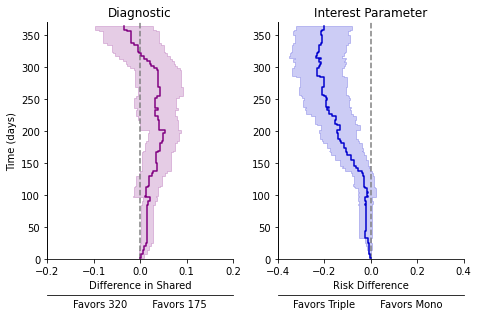

In [31]:
# Generating 1-by-2 plot of the results
f, ax = plt.subplots(1, 2, figsize=(6.75, 4.5))

# Diagnostic plot
ax[0].vlines(0, 0, 370, colors='gray', linestyles='--')
ax[0].step(diag_est, [event_t[1], ] + event_t[2:] + [event_t[-1]], color='purple', where='post')
ax[0].fill_betweenx(event_t, diag_lcl, diag_ucl, alpha=0.2, color='purple', step='post')
ax[0].set_xlabel("Difference in Shared")
ax[0].set_ylabel("Time (days)")
ax[0].set_xlim([-0.2, 0.2])
ax[0].set_ylim([0, 370])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax02 = ax[0].twiny()  # Duplicate the x-axis to create a separate label
ax02.set_xlabel("Favors 320" + "\t".expandtabs() + "Favors 175", fontdict={"size": 10})
ax02.set_xticks([])
ax02.xaxis.set_ticks_position('bottom')
ax02.xaxis.set_label_position('bottom')
ax02.spines['bottom'].set_position(('outward', 36))
ax02.spines['top'].set_visible(False)
ax02.spines['right'].set_visible(False)
ax[0].set_title("Diagnostic")

# Risk Difference of Interest plot
ax[1].vlines(0, 0, 370, colors='gray', linestyles='--')
ax[1].step(brdg_est, [event_t[1], ] + event_t[2:] + [event_t[-1]], color='mediumblue', where='post')
ax[1].fill_betweenx(event_t, brdg_lcl, brdg_ucl, alpha=0.2, color='mediumblue', step='post')
ax[1].set_xlabel("Risk Difference")
ax[1].set_xlim([-0.4, 0.4])
ax[1].set_ylim([0, 370])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax12 = ax[1].twiny()  # Duplicate the x-axis to create a separate label
ax12.set_xlabel("Favors Triple" + "\t".expandtabs() + "Favors Mono  ", fontdict={"size": 10})
ax12.set_xticks([])
ax12.xaxis.set_ticks_position('bottom')
ax12.xaxis.set_label_position('bottom')
ax12.spines['bottom'].set_position(('outward', 36))
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax[1].set_title("Interest Parameter")

plt.tight_layout()

End of examples

## References

Breskin A, Cole SR, Edwards JK, Brookmeyer R, Eron JJ, & Adimora AA. (2021). Fusion designs and estimators for treatment effects. *Statistics in Medicine*, 40(13), 3124-3137.

Cole SR, Edwards JK, Breskin A, Rosin S, Zivich PN, Shook-Sa BE, & Hudgens MG. (2022). Illustration of Two Fusion Designs and Estimators. *American Journal of Epidemiology*.

Morris TP, Walker AS, Williamson, EJ et al. (2022) Planning a method for covariate adjustment in individually randomised trials: a practical guide. *Trials* 23, 328

Wilson E, Free C, Morris TP, et al. (2017). Internet-accessed sexually transmitted infection (e-STI) testing and results service: a randomised, single-blind, controlled trial. *PLOS Medicine*, 14(12).

Zivich PN, Cole SR, & Breskin A. (2021). Twister Plots for Time-to-Event Studies. *American Journal of Epidemiology*, 190(12), 2730-2731.

Zivich PN, Cole SR, Edwards JK, Shook-Sa BE, Breskin A, & Hudgens MG. (2022). Bridged treatment comparisons: an illustrative application in HIV treatment. *arXiv preprint* arXiv:2206.04445.